In [1]:
import os
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import pytesseract

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # 설치한 패키지 간 충돌이 있어도 무시하고 실행하기 위한 코드

In [3]:
# 훈련, 검증, 테스트 데이터 이미지 경로를 리스트에 저장해줌
train_img_list = glob('E:/urclass/Projects/CP1/yolov5/car_plate/train/images/*.jpg')
valid_img_list = glob('E:/urclass/Projects/CP1/yolov5/car_plate/valid/images/*.jpg')
test_img_list = glob('E:/urclass/Projects/CP1/yolov5/car_plate/test/images/*.jpg')

In [4]:
with open('./train.txt', 'w') as f:
  f.write('\n'.join(train_img_list) + '\n')
  
with open('./valid.txt', 'w') as f:
  f.write('\n'.join(valid_img_list) + '\n')

with open('./test.txt', 'w') as f:
  f.write('\n'.join(test_img_list) + '\n')

In [5]:
# 입력 이미지 사이즈는 640, batch-size 16, epochs 50으로 설정하였고, weights, config는 yolo5l 모델로 설정해 학습을 진행하였음.(하드웨어 한계 때문에 학습은 Colab으로 진행)
!python E:/urclass/Projects/CP1/yolov5/train.py --img 640 --batch 16 --epochs 50 --data E:/urclass/Projects/CP1/yolov5/data/car_plate.yaml --name car_plate_results --weights yolov5l.pt --cfg E:/urclass/Projects/CP1/yolov5/models/yolov5l.yaml

In [6]:
# Colab에서 학습을 완료한 모델을 사용하여 샘플 이미지 예측을 수행
!python E:/urclass/Projects/CP1/yolov5/detect.py --weights E:/urclass/Projects/CP1/yolov5/runs/train/modelv5/weights/best.pt --img 640 --conf 0.5 --source E:/carimg.jpg --name detect_result

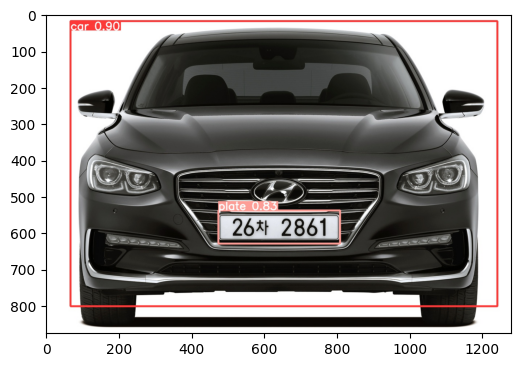

In [8]:
# 예측 결과 출력
result = Image.open('E:/urclass/Projects/CP1/yolov5/runs/detect/detect_result2/carimg.jpg')
plt.figure(figsize = (6, 5))
plt.imshow(result)
plt.show()

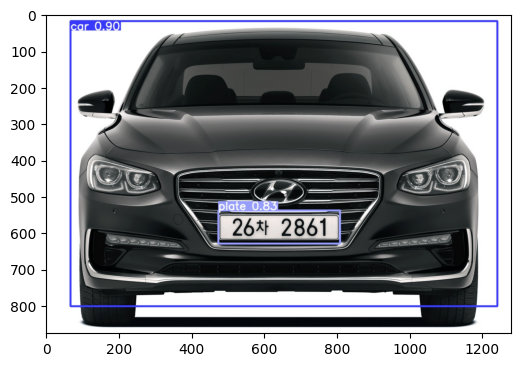

In [9]:
img_car = cv2.imread('E:/urclass/Projects/CP1/yolov5/runs/detect/detect_result2/carimg.jpg')

height, width, channel = img_car.shape

plt.figure(figsize = (6, 5))
plt.imshow(img_car, cmap = 'gray')

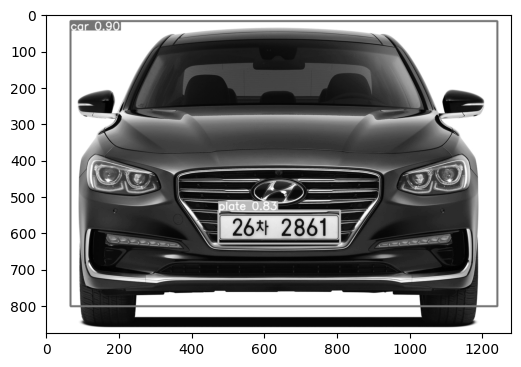

In [10]:
# gray-scale
gray = cv2.cvtColor(img_car, cv2.COLOR_BGR2GRAY)

plt.figure(figsize = (6, 5))
plt.imshow(gray, cmap = 'gray')

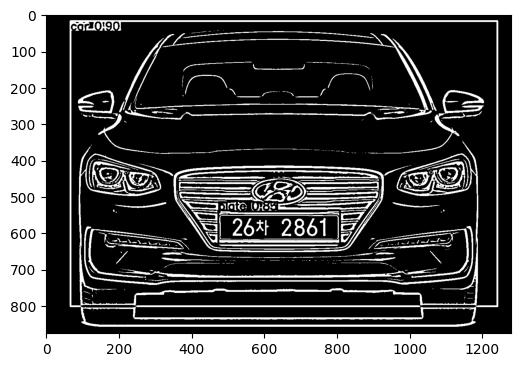

In [11]:
# 가우시안 블러를 사용하여 노이즈를 제거
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

# 이미지에 threshold를 적용, 이미지 구분 쉽게
img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue  =255.0, 
    adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType = cv2.THRESH_BINARY_INV, 
    blockSize = 19, 
    C = 9
)

plt.figure(figsize=(6, 5))
plt.imshow(img_thresh, cmap='gray')

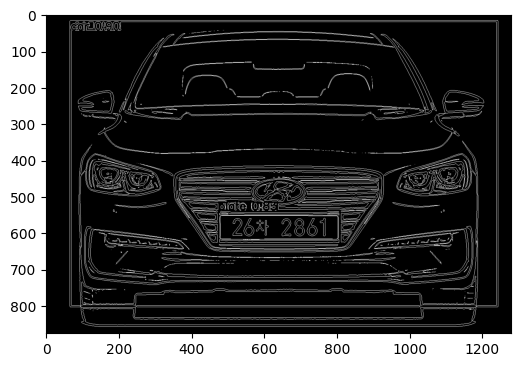

In [12]:
# 이미지의 윤곽선을 찾음
contours, hier = cv2.findContours(
    img_thresh, 
    cv2.RETR_LIST,
    cv2.CHAIN_APPROX_NONE,
)

# 
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# 찾은 윤곽선을 그려줌
cv2.drawContours(temp_result, contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(6, 5))
plt.imshow(temp_result) 

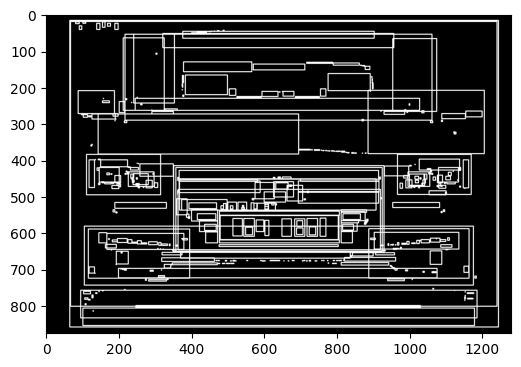

In [13]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

# 윤곽선을 감싸는 사각형을 구해서 좌표를 저장해줌
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

# 구해진 boundingRect들을 출력
plt.figure(figsize=(6, 5))
plt.imshow(temp_result, cmap='gray')

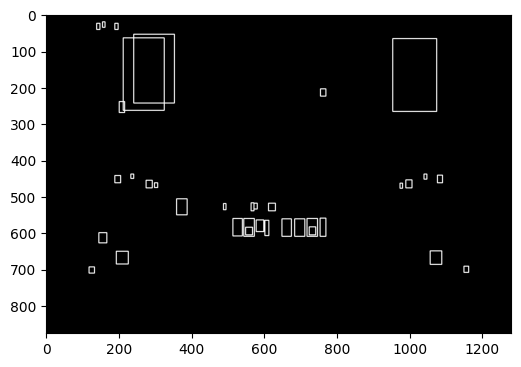

In [14]:
# 번호판이 아닌 boundingRect를 걸러주기 위한 코드

MIN_AREA = 80 # boundingRect의 최소 size
MIN_WIDTH, MIN_HEIGHT = 2, 8 # 최소 넓이, 높이
MIN_RATIO, MAX_RATIO = 0.25, 1.0 # 가로대비 세로의 길이 비율

possible_contours = []

# 조건에 맞는 윤곽선들만 possible_contours에 append 해준다.
for cnt, d in enumerate(contours_dict):
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(6, 5))
plt.imshow(temp_result, cmap='gray')

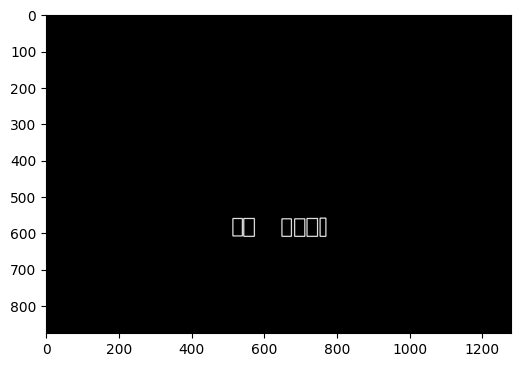

In [15]:
# 윤곽선들의 배열이 일자로 되어있는 boundingRect는 번호판일 가능성이 높기 때문에 찾아줌.

MAX_DIAG_MULTIPLYER = 5 # boundingRect의 대각선의 길이가 5배이상 차이나면 안됨
MAX_ANGLE_DIFF = 12.0 # 각도차이 12
MAX_AREA_DIFF = 0.5 # 너비차이
MAX_WIDTH_DIFF = 0.8 # 면적차이
MAX_HEIGHT_DIFF = 0.2 # 높이차이
MIN_N_MATCHED = 5 # 3 # 위의 조건들을 만족하는 boundingRect의 개수가 5개 미만이면 거름


def find_chars(contour_list):
    matched_result_idx = []
    
    # contour d1이랑 d2를 비교한다
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            # 두 contour의 중앙 거리 길이를 구함
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            
            # 거리차이
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            
            # 각도차이
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            
            # 면적, 너비, 높이차이
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            # 기준에 맞는 contour의 index를 append
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        # 후보군이 기준에 맞는 contour 수가 5 미만이면 패스
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        # 기준에 맞지 않더라도 한 번 더 확인
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(6, 5))
plt.imshow(temp_result, cmap='gray')

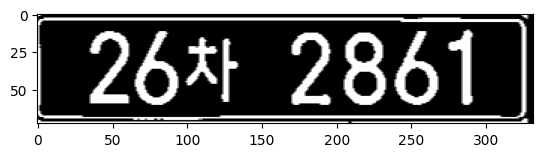

In [16]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

# 비뚤어진 번호판을 정렬해줌
for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    # 번호판의 중심 x좌표와 y좌표 구함
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    # 번호판 너비
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    # 번호판 높이
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    # 번호판이 일자로 있을 때 대비 비뚤어졌을때의 각도차를 구한다.
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    # radian -> degree
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    # 구한 각도차를 통해 rotation matrix 구해줌
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    # 구한 rotation matrix를 가지고 affine을 통해 회전
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    # 번호판만 자름
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

26차 2861


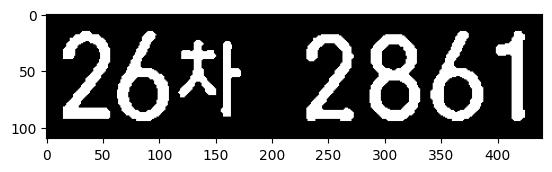

In [17]:
longest_idx, longest_text = -1, 0
plate_chars = []


# 자른 이미지에 threshold 재적용
for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # 윤곽선을 다시 찾는다
    contours, hier = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    # 다시 기준에 맞는 boundingRect 찾음
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
    
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    # 가우시안 블러로 노이즈 제거
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    
    # threshold
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # padding
    img_result = cv2.copyMakeBorder(img_result, top=15, bottom=15, left=15, right=15, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    # tesseract를 통해 이미지에서 문자 추출. psm 8(텍스트를 하나의 단어로 취급) 여러 psm중 가장 정확해서 사용
    plate_num = pytesseract.image_to_string(img_result, lang = 'kor', config = '--psm 8')
    
    # 읽은 글자중 숫자 하나라도 있는 문자열 넣어줌
    result_chars = ''
    has_digit = False
    for c in plate_num:
      has_digit = True
      result_chars += c
    
    # 결과 출력
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')

26차2861


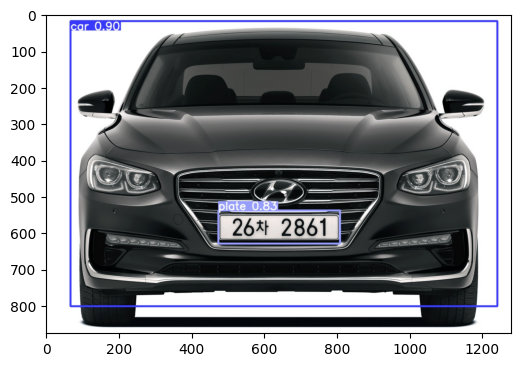

In [28]:
# 원본 이미지와 차량번호 출력
info = plate_infos[longest_idx]
plate_num = plate_chars[longest_idx].replace(' ', '')

print(plate_num)

img_out = img_car.copy()
plt.figure(figsize=(6, 5))
plt.imshow(img_out)

In [46]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from urllib.parse import quote_plus
from urllib.request import urlopen
import time

In [73]:
# 카히스토리 사이트에서 추출한 차량번호를 검색하기 위한 함수
def request(plate_num):
    url = 'https://www.carhistory.or.kr/main.car?realm='
    options = webdriver.ChromeOptions()
    options.add_experimental_option('detach', True) # 검색을 한 이후에도 브라우저가 종료되지 않도록 옵션을 줌.
    
    driver = webdriver.Chrome('chromedriver', options = options)
    driver.get(url)

    time.sleep(0.5)

    req = driver.find_element(By.NAME, "carnum") # 카히스토리 차량 번호 조회 텍스트박스
    button = driver.find_element(By.ID, 'allAgree') # 검색 후 약관동의 버튼
    
    req.send_keys(plate_num) # 추출한 차량번호를 텍스트박스에 입력해줌
    req.submit() # submit
    
    time.sleep(3)
    button.click() # 3초간 기다린 뒤, 약관 전체 동의 버튼을 눌러준다.


In [75]:
request(plate_num) # 카히스토리 조회 결과 조회 가능이면 등록된 차량, 조회 불가능이면 미등록 차량임. 조회 불가능인 경우 검거. 실제 등록된 차량 번호로 검색해보면 조회 가능이라고 뜸 ex)'27오7076'